# Segment Regridded ICON Data

## Load Libraries 

In [1]:
import healpy

import intake
import cartopy.crs as ccrs
import cartopy.feature as cf

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import pandas as pd

import scipy.ndimage
import seaborn as sns

ERROR 1: PROJ: proj_create_from_database: Open of /work/bb1153/b380352/python/env4intake-seg/share/proj failed


## Open Data 

In [2]:
time_str = '2022-07-01'
vname = 'precip'
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
exp_id = "ngc4008"
zoom = 9
dataset = cat.ICON[exp_id](zoom=zoom, time = 'PT3H',
                          # chunks = 'auto'
                          ).to_dask( )
display(dataset)

<xarray.Dataset>
Dimensions:                              (time: 87664, depth_half: 73,
                                          cell: 3145728, crs: 1,
                                          depth_full: 72, level_full: 90,
                                          soil_depth_water_level: 5,
                                          soil_depth_energy_level: 5,
                                          level_half: 91)
Coordinates:
  * crs                                  (crs) float32 nan
  * depth_full                           (depth_full) float32 1.0 ... 5.816e+03
  * depth_half                           (depth_half) float32 0.0 ... 5.951e+03
  * level_full                           (level_full) int32 1 2 3 4 ... 88 89 90
  * soil_depth_energy_level              (soil_depth_energy_level) float32 0....
  * soil_depth_water_level               (soil_depth_water_level) float32 0.0...
  * time                                 (time) datetime64[ns] 2020-01-01T03:...
    zg                                   (level_full, cell) float32 ...
Dimensions without coordinates: cell, level_half
Data variables: (12/85)
    A_tracer_v_to                        (time, depth_half, cell) float32 ...
    Qbot                                 (time, cell) float32 ...
    Qtop                                 (time, cell) float32 ...
    Wind_Speed_10m                       (time, cell) float32 ...
    atmos_fluxes_FrshFlux_Evaporation    (time, cell) float32 ...
    atmos_fluxes_FrshFlux_Precipitation  (time, cell) float32 ...
    ...                                   ...
    v_vint                               (time, cell) float32 ...
    va                                   (time, level_full, cell) float32 ...
    vas                                  (time, cell) float32 ...
    w                                    (time, depth_half, cell) float32 ...
    zghalf                               (level_half, cell) float32 ...
    zos                                  (time, cell) float32 ...

In [3]:
dataset = dataset.sel(time = time_str)

In [4]:
thresh_set = {}
thresh_set['precip'] = 50
thresh_set['fwp'] = 100.
thresh_set['cllvi'] = 100.

## Prepare Data 

In [5]:
dataset['precip'] = 3600 * 24 * ( dataset['pr'] )  # unit convetion to mm day-1

dataset['precip'].attrs['units'] = 'mm day-1'

dataset['precip'].attrs['long_name'] = 'rain rate'


In [6]:
dataset['fwp'] = 1e3* (dataset['clivi'] + dataset['qsvi'])

dataset['fwp'].attrs['units'] = 'g m-2'

dataset['fwp'].attrs['long_name'] = 'frozen water path'


## Resample Data

In [7]:
def get_nn_lon_lat_index(nside, lons, lats):
    lons2, lats2 = np.meshgrid(lons, lats)
    
    lon = xr.DataArray(lons, dims=("lon",), name="lon", attrs=dict(units="degrees", standard_name="longitude"))
    lat = xr.DataArray(lats, dims=("lat",), name="lat", attrs=dict(units="degrees", standard_name="latitude"))
    
    pix = xr.DataArray(
        healpy.ang2pix(dataset.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
        coords=(lat, lon),
    )
    return pix

In [8]:
idx = get_nn_lon_lat_index(
    2**zoom, np.arange(-180, 180, 0.1), np.arange(-30, 30, 0.1)
)

In [9]:
vlist = [vname,]

In [10]:
d = dataset[vlist]
d_lon_lat = d.isel(cell=idx)

In [11]:
d_lon_lat

<xarray.Dataset>
Dimensions:  (time: 8, lat: 600, lon: 3600)
Coordinates:
  * time     (time) datetime64[ns] 2022-07-01 ... 2022-07-01T21:00:00
  * lat      (lat) float64 -30.0 -29.9 -29.8 -29.7 -29.6 ... 29.6 29.7 29.8 29.9
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
Data variables:
    precip   (time, lat, lon) float64 2.051e-10 2.051e-10 ... 4.956e-12 2.31e-05

In [12]:

ts = pd.to_datetime(dataset.time)

#time_str = ts.to_pydatetime()[itime].strftime('%Y-%m-%d_%H%M')

## Using tobac Feature Detection for Segmentation 

In [13]:
import tobac

### Lon/Lat 

In [14]:
dlon = d_lon_lat.lon.diff('lon').mean().data
dlat = d_lon_lat.lat.diff('lat').mean().data

lat0 = d_lon_lat.lat.data

### Equivalent Grid Size

In [15]:
R_earth = 6371e3

dlambda = np.deg2rad( dlon )
dphi = np.deg2rad( dlat )
phi0 = np.deg2rad( lat0 )

dA = R_earth**2 * np.cos( phi0 ) * dphi * dlambda

dX = np.sqrt( dA.mean() )
print(dX)

10866.02271471964


### Conversion to Iris.Cube 

In [16]:
RR = d_lon_lat[vname].to_iris()

In [17]:
RR

Rain Rate (mm day-1),time,latitude,longitude
Shape,8,600,3600
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x


In [18]:
dxy = dX

### Segmentation 

In [19]:
thresholds = [thresh_set[vname],]#9,10] #np.arange(8,11)  )
print(thresholds)

# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=thresh_set[vname]  # mm/h mixing ratio


[50]


In [20]:
statistics = {}
statistics[f'mean_{vname}'] = np.mean
statistics[f'total_{vname}'] = np.sum
statistics[f'max_{vname}'] = np.max
#statistics[f'percentiles_{vname}'] = (np.percentile, {'q': [90,95,99]})

In [21]:
features = tobac.feature_detection_multithreshold(
    RR, dxy, thresholds, target="maximum", position_threshold="weighted_diff", statistic=statistics
)

In [22]:
Mask_Precip,Features_Precip=tobac.segmentation_2D(features,RR,dxy,**parameters_segmentation)


In [23]:
area = tobac.calculate_area(features, Mask_Precip)

/work/bb1153/b380352/python/env4intake-seg/lib/python3.10/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


In [54]:
final_features = area

In [55]:
final_features["time"] = xr.CFTimeIndex(final_features["time"].to_numpy()).to_datetimeindex()

xfeat = final_features.to_xarray()

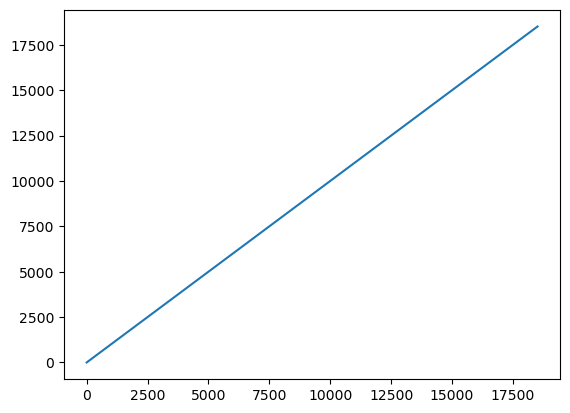

In [56]:
import pylab as plt
plt.plot(xfeat.index.data)

In [ ]:
output_dir = '/work/bb1153/b380352/data/precip_features'

outfile = f'{output_dir}/{vname}_features_thresh50_{time_str}.nc'
#ff = xfeat.to_netcdf( outfile )

## Epiloque

In [ ]:
dataset.time

In [ ]:
listfile = '/home/b/b380352/proj/2024-03_warmworld-hackathon/scripts/full_feature_detect.lst'
f = open( listfile , 'w')
for i in range(0, 40912): #len(dataset.time),2 ):
    f.write('%s\n' % str(i))
    
f.close()